In [2]:
import numpy as np
import pandas as pd
import sys
import pickle
import xml.etree.ElementTree as ET
sys.path.append('../../scripts/beastAnalysis')  # need to import from working directory
import beastmatrix as bm

In [3]:
#################### Parse and reformat input #####################
main = {}
main['burnin'] = 2500000
main['logfile'] = '../../beast/main/discreteTraits/log/discreteTraits_2016-10-25.log'
main['xmlfile'] = '../../beast/main/discreteTraits/xml/discreteTraits_2016-10-25.xml'
main['trait'] = 'host'
main['prior'] = 20

supplement = {}
supplement['burnin'] = 20000000
supplement['logfile'] = '../../beast/supplement/discreteTraits/log/discreteTraits_2016-12-27.log'
supplement['xmlfile'] = '../../beast/supplement/discreteTraits/xml/discreteTraits_2016-12-27.xml'
supplement['trait'] = 'host'
supplement['prior'] = 20

datasets = [main, supplement]

common_names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))

In [4]:
supplement['log_data'] = pd.read_csv(supplement['logfile'], skiprows=2, sep="\t", index_col='state')	#parse the log file as a df
main['log_data'] = pd.read_csv(main['logfile'], skiprows=2, sep="\t", index_col='state')

main_xml = ET.parse(main['xmlfile'])
main_root = main_xml.getroot()												#get the list of states, in order, from the xml
main_states = [ i for i in main_root.findall('generalDataType') if i.get('id').startswith(main['trait'])][0]
main['state_list'] = [ common_names[state.get('code') ] for state in main_states]
main['n_demes'] = len(main['state_list'])

supplement_xml = ET.parse(supplement['xmlfile'])
supplement_root = supplement_xml.getroot()												#get the list of states, in order, from the xml
supplement_states = [ i for i in supplement_root.findall('generalDataType') if i.get('id').startswith(supplement['trait'])][0]
supplement['state_list'] = [ common_names[state.get('code') ] for state in supplement_states]
supplement['n_demes'] = len(supplement['state_list'])

################# Deal with burnin, make data structures ###############################

for d in datasets:
    assert d['burnin'] in d['log_data'].index, (d['burnin'], d['log_data'].index)
    burnin_indices = range(0, d['log_data'].index.get_loc(d['burnin'])+1)
    d['log_data'].drop(d['log_data'].index[burnin_indices], inplace=True)
    d['log_data'] = d['log_data'].append(pd.DataFrame(d['log_data'].mean(), columns=['avg']).T)
    d['bf'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])
    d['ar'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])
    d['indicator'] = pd.DataFrame(dtype = 'float', index=d['state_list'], columns=d['state_list'])

    indicator_series = []
    actualRates_series = []
    bf_series = []
    for column, series in d['log_data'].iteritems():					#pull the average posterior values from appropriate columns in order
        if 'actualRates' in column and main['trait'] in column:			#we will then use this to fill our matrices.
            actualRates_series.append(series['avg'])
        elif 'indicator' in column and main['trait'] in column:
            bf_series.append(bm.find_bf(series['avg'], d['prior'], d['n_demes']))	#convert indicators to bayes factors while we're at it
            indicator_series.append(series['avg'])
        else:
            continue

    d['bf'] = bm.fill_rates_matrix(d['bf'], pd.Series(bf_series))
    d['ar'] = bm.fill_rates_matrix(d['ar'], pd.Series(actualRates_series))
    d['indicator'] = bm.fill_rates_matrix(d['indicator'], pd.Series(indicator_series))


In [6]:
data = []
shared_states = set(main['state_list']).intersection(set(supplement['state_list']))
for from_state in shared_states:
    for to_state in shared_states:
        if from_state != to_state:
            data.append({
            'from_%s'%main['trait']: from_state,
            'to_%s'%main['trait']: to_state,
            'main_bf': main['bf'].at[from_state, to_state],
            'main_ar': main['ar'].at[from_state, to_state],
            'main_indicator': main['indicator'].at[from_state, to_state],
            'supplement_bf': supplement['bf'].at[from_state, to_state],
            'supplement_ar': supplement['ar'].at[from_state, to_state],
            'supplement_indicator': supplement['indicator'].at[from_state, to_state],
            })

compare = pd.DataFrame(data, columns = ['from_%s'%main['trait'], 'to_%s'%main['trait'], 
                                        'main_indicator', 'main_bf', 'main_ar',
                                       'supplement_indicator', 'supplement_bf', 'supplement_ar'])

# compare['main_bf'] = compare['main_bf'].map(np.log)
# compare['supplement_bf'] = compare['supplement_bf'].map(np.log)

In [7]:
compare.sort_values('supplement_bf', inplace=True)
compare

,from_host,to_host,main_indicator,main_bf,main_ar,supplement_indicator,supplement_bf,supplement_ar
150,Red-capped_Mangabey,Human,0.014889,4.020275e-01,0.001894,0.0160,1.544706e-01,0.001600
205,Chimp_pts,Vervet,0.029556,8.101185e-01,0.006597,0.0256,2.495885e-01,0.004556
78,Chimp_ptt,Vervet,0.031778,8.730291e-01,0.005669,0.0270,2.636167e-01,0.003922
81,Chimp_ptt,Sabaeus_Monkey,0.033111,9.109142e-01,0.006670,0.0308,3.018975e-01,0.005075
140,Red-capped_Mangabey,Baboon,0.038889,1.076298e+00,0.012504,0.0314,3.079693e-01,0.005859
208,Chimp_pts,Sabaeus_Monkey,0.031111,8.541256e-01,0.006673,0.0324,3.181056e-01,0.005253
35,Mandrill,Sooty_Mangabey,0.025111,6.851579e-01,0.004819,0.0328,3.221661e-01,0.005850
77,Chimp_ptt,Sooty_Mangabey,0.025556,6.976027e-01,0.005503,0.0330,3.241975e-01,0.006181
38,Mandrill,Human,0.014444,3.898507e-01,0.002209,0.0340,3.343675e-01,0.006759
36,Mandrill,Vervet,0.026000,7.100588e-01,0.004244,0.0342,3.364040e-01,0.004816


In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy

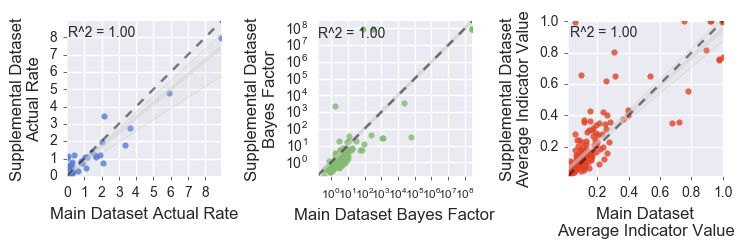

In [9]:
fig, (ar_ax, bf_ax, ind_ax) = plt.subplots(figsize=(7.5,2.5),nrows=1,ncols=3, facecolor='w') # Note shared Y axis
bf_ax.set(xscale='log', yscale='log') # Plot BF on log scale

ar_reg = sns.regplot(compare['main_ar'], compare['supplement_ar'], ax=ar_ax, 
                     scatter_kws={'color': '#547BD3'},
                     line_kws={'color': 'lightgray', 'alpha': 0.5})

ind_reg = sns.regplot(compare['main_indicator'], compare['supplement_indicator'], ax=ind_ax,
                      scatter_kws={'color': '#DF4327'},
                      line_kws={'color': 'lightgray', 'alpha': 0.5})

bf_points = sns.regplot(compare['main_bf'], compare['supplement_bf'],
                        scatter_kws={'color': '#83BA70'}, ax=bf_ax, fit_reg=False) # Plot raw points on log scale
bf_reg = sns.regplot(compare['main_bf'].map(np.log10), compare['supplement_bf'].map(np.log10), ax=bf_ax, # Do regression on logged points
            line_kws={'color': 'lightgray', 'alpha': 0.5}, scatter_kws={'alpha': 0})

ar_lims = [ min(compare['main_ar'].min(), compare['supplement_ar'].min()), # Plot x=y
           max(compare['main_ar'].max(), compare['supplement_ar'].max())]
ar_ax.plot(ar_lims, ar_lims, '--', color='k', alpha=0.5)
ar_ax.set_xlim(ar_lims) # Set axis limits
ar_ax.set_ylim(ar_lims)
ar_reg_x, ar_reg_y = ar_reg.get_lines()[0].get_xdata(), ar_reg.get_lines()[0].get_ydata() # Get R^2
ar_R_squared = scipy.stats.linregress(ar_reg_x, ar_reg_y)[2]**2 # slope, intercept, r_value, p_value, std_err
ar_ax.text(ar_lims[0]+0.01*ar_lims[1], ar_lims[1]-0.1*ar_lims[1], 'R^2 = %.2f'%ar_R_squared)

bf_lims = [ min(compare['main_bf'].min(), compare['supplement_bf'].min()), 
           max(compare['main_bf'].max(), compare['supplement_bf'].max())]
bf_ax.plot(bf_lims, bf_lims, '--', color='k', alpha=0.5)
bf_ax.set_xlim(bf_lims)
bf_ax.set_ylim(bf_lims)
bf_reg_x, bf_reg_y = bf_reg.get_lines()[0].get_xdata(), bf_reg.get_lines()[0].get_ydata() # Get R^2
bf_R_squared = scipy.stats.linregress(bf_reg_x, bf_reg_y)[2]**2 # slope, intercept, r_value, p_value, std_err
bf_ax.text(bf_lims[0], bf_lims[1]-0.9*bf_lims[1], 'R^2 = %.2f'%bf_R_squared)


ind_lims = [ min(compare['main_indicator'].min(), compare['supplement_indicator'].min()), 
           max(compare['main_indicator'].max(), compare['supplement_indicator'].max())]
ind_ax.plot(ind_lims, ind_lims, '--', color='k', alpha=0.5)
ind_ax.set_xlim(ind_lims)
ind_ax.set_ylim(ind_lims)
ind_reg_x, ind_reg_y = ind_reg.get_lines()[0].get_xdata(), ind_reg.get_lines()[0].get_ydata() # Get R^2
ind_R_squared = scipy.stats.linregress(ind_reg_x, ind_reg_y)[2]**2 # slope, intercept, r_value, p_value, std_err
ind_ax.text(ind_lims[0]+0.01*ind_lims[1], ind_lims[1]-0.1*ind_lims[1], 'R^2 = %.2f'%ind_R_squared)

ind_ax.set_xlabel('Main Dataset\nAverage Indicator Value', size=12) # Label axes
ind_ax.set_ylabel('Supplemental Dataset\nAverage Indicator Value', size=12)
ar_ax.set_xlabel('Main Dataset Actual Rate', size=12)
ar_ax.set_ylabel('Supplemental Dataset\nActual Rate', size=12)
bf_ax.set_xlabel('Main Dataset Bayes Factor', size=12)
bf_ax.set_ylabel('Supplemental Dataset\nBayes Factor', size=12)

ind_ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
ar_ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
bf_ax.tick_params(axis='x', which='major', labelsize=8.5, width=0.5, length=3, top="off", right="off")


ind_ax.spines['left'].set_linewidth(0.5)
ind_ax.spines['bottom'].set_linewidth(0.5)
ar_ax.spines['left'].set_linewidth(0.5)
ar_ax.spines['bottom'].set_linewidth(0.5)
bf_ax.spines['left'].set_linewidth(0.5)
bf_ax.spines['bottom'].set_linewidth(0.5)

sns.set_style(style='white') # Make it pretty
plt.tight_layout()

plt.savefig('../png/FigS9.png', bbox_inches='tight', dpi=600)
compare.to_csv('../../beast/compare_discreteTraits.csv')

### Figure S9: Comparison of Main and Supplemental Dataset Discrete Trait Analysis Results

Each datapoint represents on of the 210 possible transmissions between each pair of the 15 hosts present in both datasets. The black dashed line shows y=x; the linear regression and 95% CI are shown in gray.